In [1]:
# Initialization code that runs before all other cells
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve,auc,confusion_matrix,precision_score,recall_score, f1_score
from preprocessing import preprocess,get_labels
from extraction import feature_extraction
import pandas as pd
import numpy as np
import marimo as mo
import seaborn as sns
import matplotlib.pyplot as plt

# Load and Extract Features from Dataset

In [2]:
df = pd.read_csv("../../data/train_data.csv",index_col=0)
X = df.pipe(preprocess,attr= ['Soil_Moisture','Ambient_Temperature','Soil_Temperature','Humidity','Soil_pH','Nitrogen_Level'])
X.head()

,Soil_Moisture,Ambient_Temperature,Soil_Temperature,Humidity,Soil_pH,Nitrogen_Level
Timestamp,,,,,,
2024-10-29 16:54:53.426551,-1.153141,-0.041673,-0.934143,-0.310509,1.565693,-1.311790
2024-10-30 10:54:53.473520,0.781295,-0.478532,0.180041,1.092487,0.290128,0.892456
2024-10-10 10:54:53.486512,-1.591389,0.381452,0.936454,1.253537,0.981499,-0.268331
2024-10-25 04:54:53.467524,0.149233,0.235021,-1.471607,-1.169741,-0.346469,-1.519919
2024-10-04 10:54:53.467524,-0.845677,1.242659,0.459259,1.033675,0.688706,-0.916270


In [3]:
y = get_labels(df)
y.head()

,Plant_Health_Status
Timestamp,
2024-10-29 16:54:53.426551,High Stress
2024-10-30 10:54:53.473520,Healthy
2024-10-10 10:54:53.486512,High Stress
2024-10-25 04:54:53.467524,High Stress
2024-10-04 10:54:53.467524,High Stress


# Create Model

In [4]:
svm = SVC(probability=True)
svm_base = SVC(probability=True)
svm

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [5]:
svm_base.fit(X,y.values.flatten())

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


# Hyper-Parameter Optimization

In [6]:
grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale','auto',0.01,0.1],
    'kernel': ['rbf','poly','sigmoid']
}

In [7]:
search = GridSearchCV(
    estimator=svm,
    param_grid=grid,
    cv = 5,
    scoring='accuracy',
    n_jobs=3
)

In [8]:
search.fit(X=X, y=y.values.flatten())

,estimator,SVC(probability=True)
,param_grid,"{'C': [0.1, 1, ...], 'gamma': ['scale', 'auto', ...], 'kernel': ['rbf', 'poly', ...]}"
,scoring,'accuracy'
,n_jobs,3
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


In [9]:
mo.md(f"""*Best training accuracy for SVM is {search.best_score_:.2f}* Multi-class predictions are handled using a One-vs-Rest Approach. 
For each class The multi-class task is converted to a binary classification of whether that sample belongs to that class.""")

_md()

In [10]:
test = pd.read_csv("../../data/test_data.csv",index_col=0)
X_test = test.pipe(preprocess, attr = ['Soil_Moisture','Ambient_Temperature','Soil_Temperature','Humidity','Soil_pH','Nitrogen_Level'])
y_test = test.pipe(get_labels)

In [11]:
optimal = search.best_estimator_
y_optimal = optimal.predict_proba(X_test)
pred_optimal = y_optimal.argmax(axis = 1)
cm = confusion_matrix(
    y_test['Plant_Health_Status'].astype('category').cat.codes,
    pred_optimal
)

In [13]:
y_base = svm_base.predict_proba(X_test)
pred_base = y_base.argmax(axis = 1)
cm_base = confusion_matrix(
    y_test['Plant_Health_Status'].astype('category').cat.codes,
    pred_optimal
)

# SVM Performance
SVM performed incredibly well. It only failed to differentiate a few samples between the moderately stressed and highly stressed classes.

Text(0.5, 1.0, 'Search Scores')

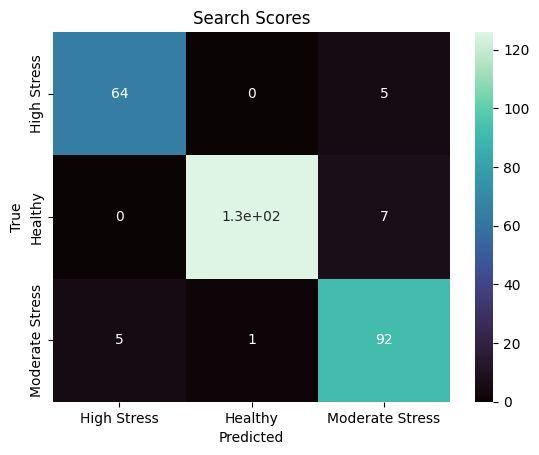

In [17]:
sns.heatmap(
    cm,annot=True,cmap='mako',
    xticklabels=y["Plant_Health_Status"].unique(),
    yticklabels=y["Plant_Health_Status"].unique()
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Search Scores")

The optimal model from the hyper-parameter search is the same as the default svm.  That makes sense in our case as both models are performing so well right from  the beginning

Text(0.5, 1.0, 'Baseline Scores')

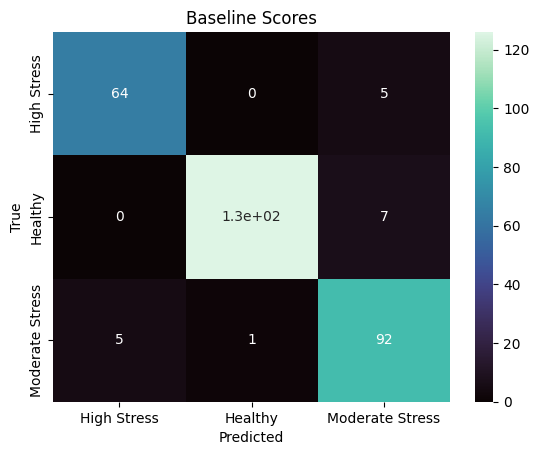

In [16]:
sns.heatmap(
    cm_base,annot=True,cmap='mako',
    xticklabels=y["Plant_Health_Status"].unique(),
    yticklabels=y["Plant_Health_Status"].unique()
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Baseline Scores")

In [19]:
o = OneHotEncoder(sparse_output=False)
y_classes = o.fit_transform(y_test)

# ROC Curves Per-Class
Both the Healthy and High Stress Classes Have been predicted well while the
Moderate Stress class has slightly lower performance overall. However all classes are predicted with over 90% AUC.

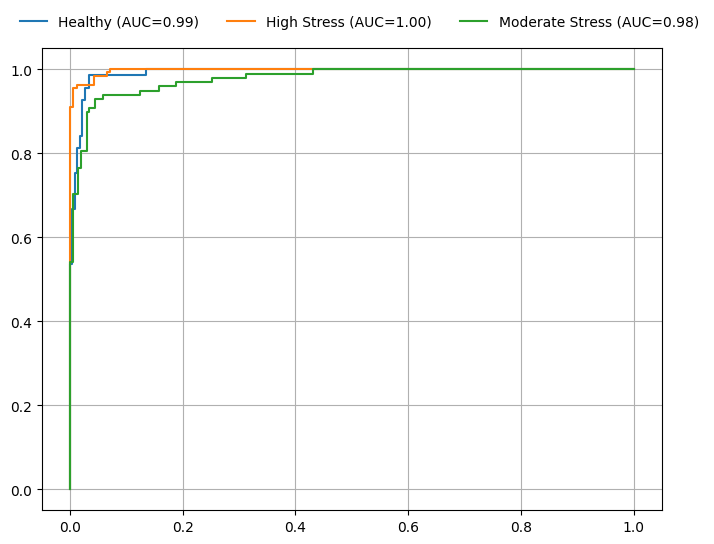

In [22]:
tprs = []
fprs = []
names = [f.split("_")[-1] for f in o.get_feature_names_out()]
plt.figure(figsize=(8,6))
for i in range(y_optimal.shape[1]):
    tpr,fpr, _ =roc_curve(y_classes[:,i],y_optimal[:,i])
    a = auc(tpr,fpr)
    tprs.append(tpr)
    fprs.append(fpr)
    plt.plot(tpr,fpr,label = f"{names[i]} (AUC={a:.2f})")
plt.legend(bbox_to_anchor = (1.08,1.1), ncol = 3,frameon = False)
plt.grid(True)
plt.show()

# Recall Precision and F1

In [24]:
precision = precision_score(pred_optimal,y_test['Plant_Health_Status'].astype('category').cat.codes,average='micro')
recall = recall_score(pred_optimal,y_test['Plant_Health_Status'].astype('category').cat.codes,average='micro')
f1 = f1_score(pred_optimal,y_test['Plant_Health_Status'].astype('category').cat.codes,average='micro')

In [25]:
mo.md(
    f"""
Average Precision: {precision:.2f}\n
Average Recall: {recall:.2f}\n
Average F1: {f1:.2f}
"""
)

_md()